In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
%matplotlib inline
sns.set_style("white")

from reV.generation.generation import Gen
from reV.handlers.resource import Resource

cwd = os.getcwd()

# Pull data from AWS using HSDS

### Solar Generation
Extract meta data and find site "gids" associated with Dist. Tehuantepec, Oaxaca

In [2]:
nsrdb_dir = '/nrel/nsrdb/'
nsrdb_file = os.path.join(nsrdb_dir, 'nsrdb_2013.h5')
with Resource(nsrdb_file, hsds=True) as f:
    meta_data = f.meta
    time_index = f.time_index
    print(f.get_dset_properties('dhi'))
    
meta_data.head()

((17520, 2018392), dtype('int16'), (2688, 372))


,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,None,None,None,None,-9999,210
1,-19.99,-175.220001,0.0,13,None,None,None,None,-9999,210
2,-19.99,-175.179993,0.0,13,None,None,None,None,-9999,210
3,-19.99,-175.139999,0.0,13,None,None,None,None,-9999,210
4,-19.99,-175.100006,0.0,13,None,None,None,None,-9999,210


In [3]:
county = 'Dist. Tehuantepec'
points = (meta_data['county'] == county) & (meta_data['state'] == 'Oaxaca')
points = meta_data.index[points].tolist()
points_meta = meta_data.loc[points]
print('Number of WTK points in {}: {}'.format(county, len(points)))

Number of WTK points in Dist. Tehuantepec: 404


Run reV Gen for all sites in Dist. Tehuantepec, Oaxaca

In [4]:
# SAM configuration for wind turbine
config_path = os.path.join(cwd, 'pv_SAM_config.json')
with open(config_path, 'r') as f:
    SAM_config = json.load(f)
    
SAM_config

{'adjust:constant': 0,
 'array_type': 2,
 'azimuth': 180,
 'capital_cost': 39767200,
 'dc_ac_ratio': 1.3,
 'fixed_charge_rate': 0.096,
 'fixed_operating_cost': 260000,
 'gcr': 0.4,
 'inv_eff': 96,
 'losses': 14.07566,
 'module_type': 0,
 'system_capacity': 20000,
 'tilt': 0,
 'variable_operating_cost': 0}

In [5]:
# Run reV Gen in series locally
ts = time.time()
gen = Gen.reV_run(tech='pv', points=points, sam_files=config_path,
                  res_file=nsrdb_file, max_workers=1, fout=None,
                  output_request=('cf_mean', 'cf_profile'))

tt = time.time() - ts
print('Time to compute generation for {} sites = {:.4f} min'
      .format(len(points), tt / 60))

Time to compute generation for 404 sites = 3.1630 min


/home/mrossol/miniconda3/envs/rev-hsds/lib/python3.7/site-packages/seaborn/utils.py:279: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


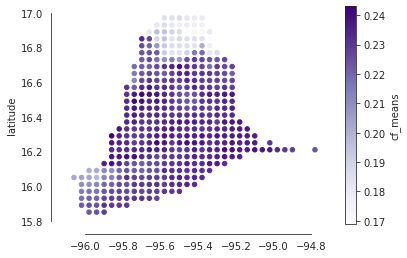

In [6]:
# Extract CF means
cf_means = points_meta[['latitude', 'longitude']].copy()
cf_means['cf_means'] = gen.out['cf_mean'] / 1000

cf_means.plot.scatter(x='longitude', y='latitude', c='cf_means', cmap='Purples')
sns.despine(offset=10, trim=True)
plt.show()

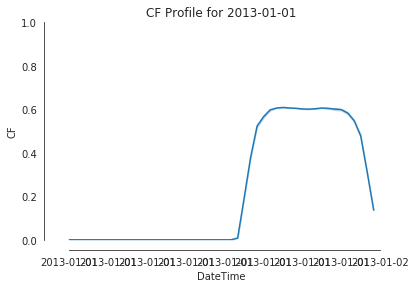

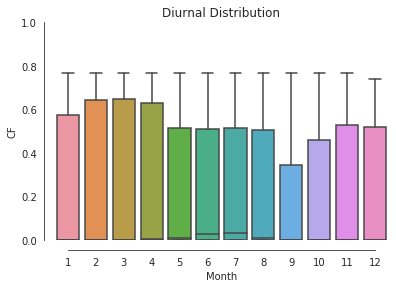

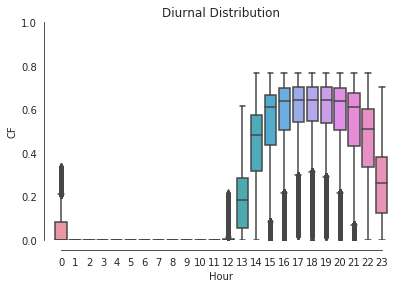

In [7]:
# Extract CF profiles
cf_profiles = pd.DataFrame(gen.out['cf_profile'] / 1000, columns=points)
cf_profiles['DateTime'] = time_index
cf_profiles['Month'] = time_index.month
cf_profiles['Hour'] = time_index.hour

sns_profiles = pd.melt(cf_profiles, id_vars=['DateTime', 'Month', 'Hour'],
                       value_name='CF')
sns_profiles.index = pd.to_datetime(sns_profiles['DateTime'])

mask = sns_profiles.index < pd.to_datetime('2013-01-02')
ax = sns.lineplot(x="DateTime", y="CF",
             markers=True, dashes=False, data=sns_profiles.loc[mask])
plt.title('CF Profile for 2013-01-01')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Month", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')

ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Hour", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()

### Wind Generation
Extract meta data and find site "gids" associated with Dist. Tehuantepec, Oaxaca

In [8]:
wtk_dir = '/nrel/wtk/mexico'
wind_file = os.path.join(wtk_dir, 'wtk_mexico_2013.h5')
with Resource(wind_file, hsds=True) as f:
    meta_data = f.meta
    time_index = f.time_index
    
meta_data.head()

,latitude,longitude,country,state,county,timezone,elevation,offshore,source
0,27.539829,-121.763748,None,None,None,-8,0,1,WTK (3Tier)
1,27.556698,-121.770096,None,None,None,-8,0,1,WTK (3Tier)
2,27.573586,-121.776443,None,None,None,-8,0,1,WTK (3Tier)
3,27.590454,-121.782791,None,None,None,-8,0,1,WTK (3Tier)
4,27.607327,-121.789154,None,None,None,-8,0,1,WTK (3Tier)


In [9]:
county = 'Dist. Tehuantepec'
points = (meta_data['county'] == county) & (meta_data['state'] == 'Oaxaca')
points = meta_data.index[points].tolist()
points_meta = meta_data.loc[points]
print('Number of WTK points in {}: {}'.format(county, len(points)))

Number of WTK points in Dist. Tehuantepec: 1913


Run reV Gen for all sites in Dist. Tehuantepec, Oaxaca

In [10]:
# SAM configuration for wind turbine
config_path = os.path.join(cwd, 'wind_SAM_config.json')
with open(config_path, 'r') as f:
    SAM_config = json.load(f)
    
SAM_config

{'adjust:constant': 0,
 'system_capacity': 1620,
 'wind_farm_losses_percent': 16.7,
 'wind_farm_wake_model': 0,
 'wind_farm_xCoordinates': [0],
 'wind_farm_yCoordinates': [0],
 'wind_resource_model_choice': 0,
 'wind_resource_shear': 0.140000001,
 'wind_resource_turbulence_coeff': 0.1,
 'wind_turbine_hub_ht': 80,
 'wind_turbine_powercurve_powerout': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  9,
  16,
  49,
  81,
  122,
  163,
  211,
  259,
  319,
  378,
  441,
  504,
  574,
  643,
  726,
  808,
  896,
  984,
  1072,
  1159,
  1236,
  1312,
  1369,
  1426,
  1473,
  1519,
  1545,
  1571,
  1583,
  1594,
  1602,
  1609,
  1614,
  1619,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,
  1620,

In [11]:
# Run reV Gen in series locally
ts = time.time()
gen = Gen.reV_run(tech='windpower', points=points, sam_files=config_path,
                  res_file=wind_file, max_workers=1, fout=None,
                  output_request=('cf_mean', 'cf_profile'))

tt = time.time() - ts
print('Time to compute generation for {} sites = {:.4f} min'
      .format(len(points), tt / 60))

Time to compute generation for 1913 sites = 2.8465 min


/home/mrossol/miniconda3/envs/rev-hsds/lib/python3.7/site-packages/seaborn/utils.py:279: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


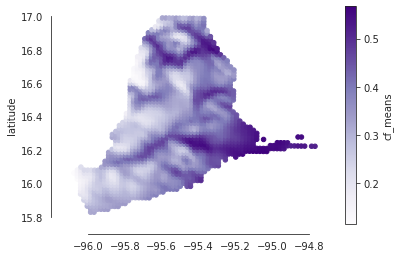

In [12]:
# Extract CF means
cf_means = points_meta[['latitude', 'longitude']].copy()
cf_means['cf_means'] = gen.out['cf_mean'] / 1000

cf_means.plot.scatter(x='longitude', y='latitude', c='cf_means', cmap='Purples')
sns.despine(offset=10, trim=True)
plt.show()

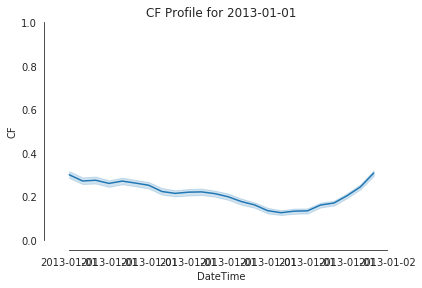

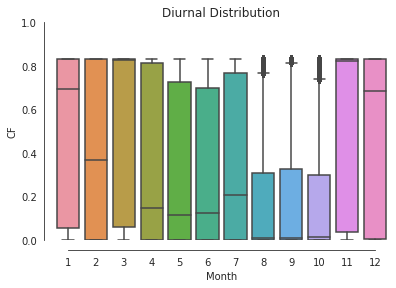

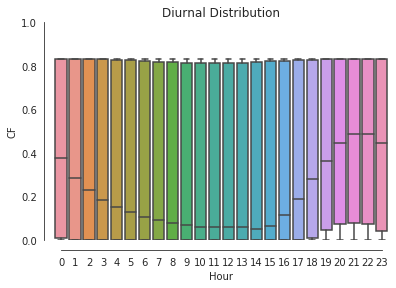

In [13]:
# Extract CF profiles
cf_profiles = pd.DataFrame(gen.out['cf_profile'] / 1000, columns=points)
cf_profiles['DateTime'] = time_index
cf_profiles['Month'] = time_index.month
cf_profiles['Hour'] = time_index.hour

sns_profiles = pd.melt(cf_profiles, id_vars=['DateTime', 'Month', 'Hour'],
                       value_name='CF')
sns_profiles.index = pd.to_datetime(sns_profiles['DateTime'])

mask = sns_profiles.index < pd.to_datetime('2013-01-02')
ax = sns.lineplot(x="DateTime", y="CF",
             markers=True, dashes=False, data=sns_profiles.loc[mask])
plt.title('CF Profile for 2013-01-01')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Month", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')

ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()


ax = sns.boxplot(x="Hour", y="CF", data=sns_profiles)
plt.title('Diurnal Distribution')
ax.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
plt.show()